In [3]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

## (2020/08/29 1:11 Yuzurihara added Japanese comment)

In [4]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math

# (yuzu)以下の2行が何をしているのか不明なので、コメントで補足が必要
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

sg.theme('Default1')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [5]:
def generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting):

    #
    # (yuzu) 関数の引数であるdic_fpmi_ispds, dic_fpmi_advanced_settingにどういう変数が入っているのかコメントで補足する
    # dic_fpmi_ispdsと dic_fpmi_advanced_settingと名前にfpmiが付いているが不要、変数が長くなるので取る
    # この関数が呼ばれた時点でFPMIなのは明らかなので
    # 
    
    ###############################
    ### get variables from GUI ###
    
    ### Optic ###
    #
    # (yuzu) pick up laser power [W] from GUI
    # 
    laser_power = dic_fpmi_advanced_setting["laser_power"]#source laser power
    
    ### DoF ###
    #
    # (yuzu) pick up DoF (CARM / DARM / BS) from GUI
    # 
    dof = dic_fpmi_advanced_setting["dof"]#CARM DARM BS
    
    ### scan/demod/double demod ###
    #
    # (yuzu) pick up sweep mode from GUI
    # 結局この3つのスウィープモードから選ばれるのは1つのモードなので、1つの変数にまとめる
    # if dic_fpmi_advanced_setting["isscan"] == True:
    #   sweep_mode = "isscan"
    # elif dic_fpmi_advanced_setting["isdemod_once"] == True:
    #   sweep_mode = "isdemod_once"
    # elif dic_fpmi_advanced_setting["istransfunc"] == True:
    # sweep_mode = "istransfunc"
    # else
    #   ここでエラーで終了するようにしておく(エラーメッセージは何もモードのオプションが選ばれていない、おそらく不要だけど念の為)
    # 
    # あとif文はここではなくて、この関数の外でやったほうが良い
    # どのモードが選ばれたかは dic_fpmi_advanced_setting という辞書型に入れておく
    # そうすると後々プロットするときに一々 if(values["issweep"] and values['isscan']==True): とかしなくても良くなる
    #
    isscan = dic_fpmi_advanced_setting["isscan"]
    isdemod_once = dic_fpmi_advanced_setting["isdemod_once"]
    istransfunc = dic_fpmi_advanced_setting["istransfunc"]
    
    #
    # (yuzu) 説明を書く
    # 
    x_plotscale = dic_fpmi_advanced_setting["x_plotscale"]
    xaxis_range_beg = dic_fpmi_advanced_setting["xaxis_range_beg"]
    xaxis_range_end = dic_fpmi_advanced_setting["xaxis_range_end"]
    y_plotscale = dic_fpmi_advanced_setting["y_plotscale"]
    #yaxis_range_beg = dic_fpmi_advanced_setting["yaxis_range_beg"]
    #yaxis_range_end = dic_fpmi_advanced_setting["yaxis_range_end"]
    samplingnum = dic_fpmi_advanced_setting["samplingnum"]

    ## pd1 advanced setting
    ## pd2 advanced setting
    # 
    # (yuzu) それぞれの変数がどういう値を持っているのか書く、True/Falseとかstringとかintとかfloatとか
    # 
    pd1_demod_phase = dic_fpmi_advanced_setting["pd1_demod_phase"]
    pd1_demodfreq = dic_fpmi_advanced_setting["pd1_demodfreq"]
    pd2_demod_phase = dic_fpmi_advanced_setting["pd2_demod_phase"]
    pd2_mixer1_demodfreq = dic_fpmi_advanced_setting["pd2_mixer1_demodfreq"]
    # default demod_phase, demod_freque is Pd1's configuration
    demod_phase = dic_fpmi_advanced_setting["pd1_demod_phase"]
    demod_freq = dic_fpmi_advanced_setting["pd1_demodfreq"]
    #
    # (yuzu) ここもsweep_mode を使うようにする、keyの名前と変数名が同じというのは誤用を招く気がするのでおすすめはしない
    #
    if(istransfunc and isdemod_once):
        demod_phase  = dic_fpmi_advanced_setting["pd2_demod_phase"]
        demod_freq = dic_fpmi_advanced_setting["pd2_mixer1_demodfreq"]
    ## note that 
    print()
    # demod_phase_I,demod_phase_Q must define after demod_phase is defined
    demod_phase_I = str(0+float(demod_phase))
    demod_phase_Q = str(90+float(demod_phase))

    
    ###############################

    ### INF components ###
    #
    # Prepare common (fixed for KAGRA) setting for kat file 
    # 
    input_finesse = """
    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nxtrans

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nytrans

    """ % (laser_power)

    ### PDs location ###
    
    # demod_num
    # demod_phase #slider?
    pd0s_code = ""
    pd1s_code = ""
    pd2s_code = ""

    #
    # (yuzu) loop for all the PDs
    #
    for key in dic_fpmi_ispds.keys():
        if dic_fpmi_ispds[key] == True:
            pd0s_code_add = """
pd0 pd0_%s %s
            """% (key,key,
                  )
            pd0s_code = pd0s_code + pd0s_code_add # input finesse ni tyokusetu tasu
            # (yuzu) input finesse ni tyokusetu tasu
 
            pd1s_code_add = """
pd1 pd1_%s_I1 $f1_SB %s %s
pd1 pd1_%s_Q1 $f1_SB %s %s
pd1 pd1_%s_I2 $f2_SB %s %s
pd1 pd1_%s_Q2 $f2_SB %s %s
pd1 pd1_%s_IX %s %s %s
pd1 pd1_%s_QX %s %s %s
            """% (key, demod_phase_I, key,
                  key, demod_phase_Q, key,
                  key, demod_phase_I, key,
                  key, demod_phase_Q, key,
                  key, demod_freq, demod_phase_I, key,
                  key, demod_freq, demod_phase_Q, key
                  )
            pd1s_code = pd1s_code + pd1s_code_add
            # (yuzu) pd1s_code_add は不要
        
            pd2s_code_add ="""
pd2 pd2_%s_I1 $f1_SB %s 10 %s
put pd2_%s_I1 f2 $x1
pd2 pd2_%s_Q1 $f1_SB %s 10 %s
put pd2_%s_Q1 f2 $x1

pd2 pd2_%s_I2 $f2_SB %s 10 %s
put pd2_%s_I2 f2 $x1
pd2 pd2_%s_Q2 $f2_SB %s 10 %s
put pd2_%s_Q2 f2 $x1

pd2 pd2_%s_IX %s %s 10 %s
put pd2_%s_IX f2 $x1
pd2 pd2_%s_QX %s %s 10 %s
put pd2_%s_QX f2 $x1
            """% (key, demod_phase_I, key,
                  key,
                  key, demod_phase_Q, key,
                  key,
                  key, demod_phase_I, key,
                  key,
                  key, demod_phase_Q, key,
                  key,
                  key, demod_freq, demod_phase_I, key,
                  key,
                  key, demod_freq, demod_phase_Q, key,
                  key
                  )
            pd2s_code = pd2s_code + pd2s_code_add
            # (yuzu) pd2s_code_add は不要
            
    input_finesse += pd0s_code+pd1s_code+pd2s_code
    
    # (yuzu) 後で消す
    #+pd2s_code
    
    if(istransfunc==True):
        
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
## DARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

# (yuzu) katファイルを出力することを考えて、自由度をkatファイルに書いておく
        elif(dof=="CARM"):
            carm_sweep = """
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

# (yuzu) katファイルを出力することを考えて、自由度をkatファイルに書いておく
        elif(dof=="BS"):
            bs_sweep = """
fsig sig1 ETMX 10 0
fsig sig1 ITMX 10 0
fsig sig1 ETMY 10 180
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass
    if(istransfunc==False):
      
        ### DoF ###

        if(dof=="DARM"):
            darm_sweep = """
# DARM scan
xaxis ETMX phi %s %s %s %s
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi %s %s %s %s
put* ETMY phi $x1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
# BS scan
#
#(koyama) original vergion og kokeyamasan uses xaxis

# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass

    code = input_finesse
    # (yuzu) デバッグのためとはいえ、このprintはもう消したほうがよい
    #print(code)
    return code


--------------------------------------------------------------
Running kat - Started at 2020-09-01 19:55:52.465106
Used Finesse 2.3.1 at /Users/yuzurihara/anaconda3/envs/mifsim37/bin/kat

Finished in 0.101369 seconds


100% | ETA:  0:00:00 | Calculating                                             

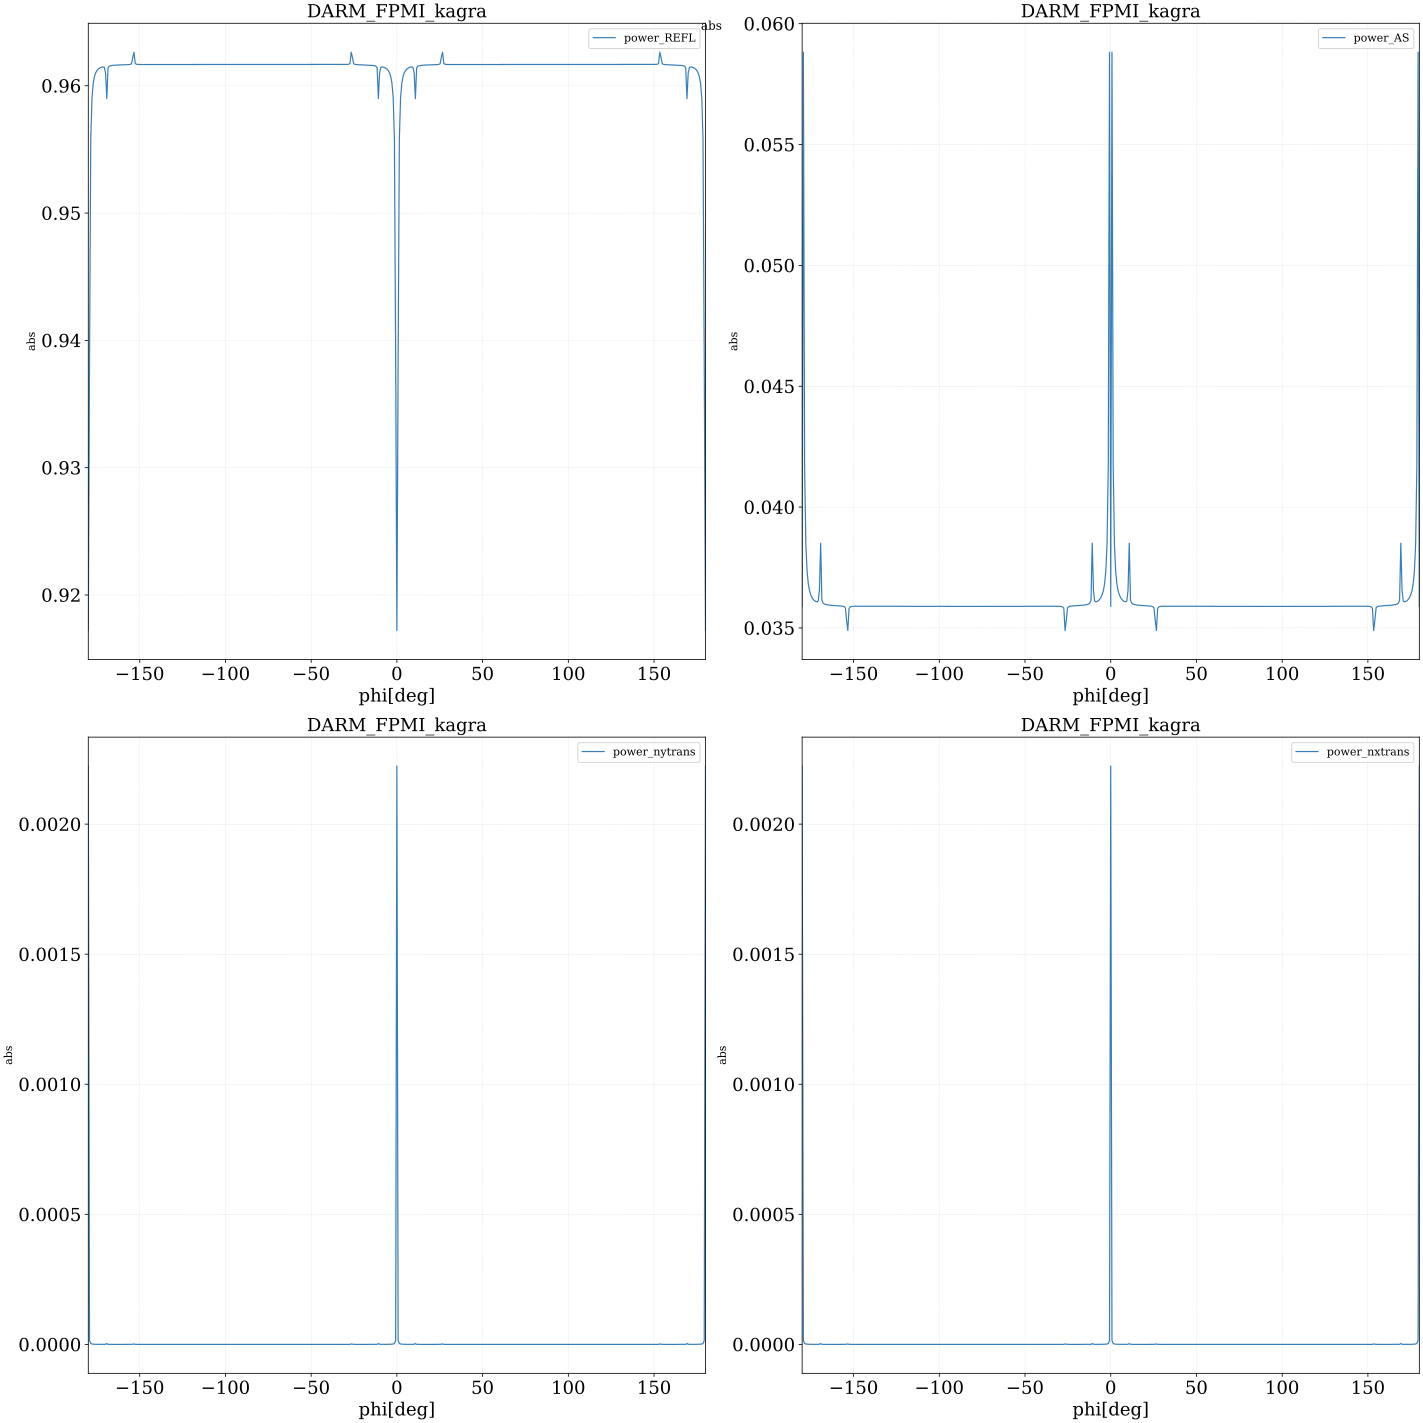


--------------------------------------------------------------
Running kat - Started at 2020-09-01 19:56:03.039013
Used Finesse 2.3.1 at /Users/yuzurihara/anaconda3/envs/mifsim37/bin/kat

Finished in 0.103803 seconds


100% | ETA:  0:00:00 | Calculating                                             

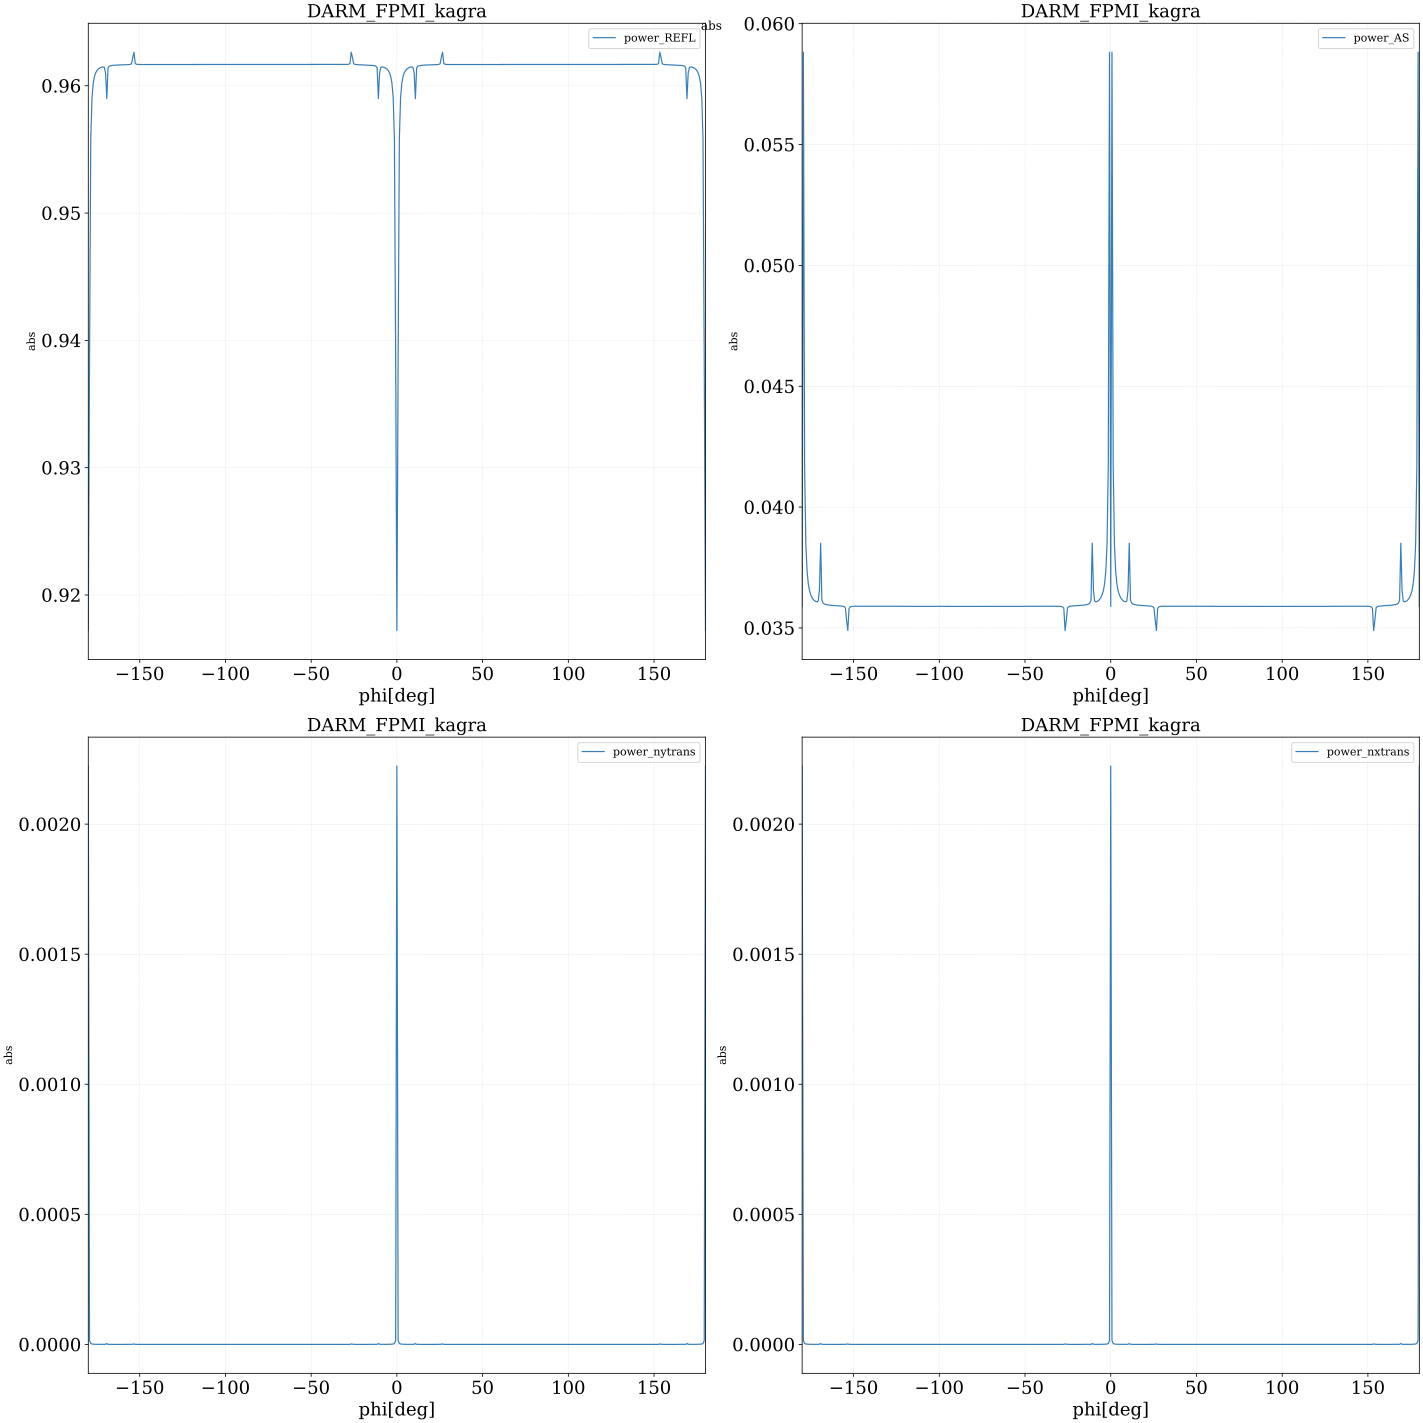

SystemExit: 0

/Users/yuzurihara/anaconda3/envs/mifsim37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
##################################    
#section setting pd0/pd1/pd2
##################################
fpmi_section_pd0 = [

            ]
#
# 
#


fpmi_section_pd1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='pd1_plot_in_phase_f1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='pd1_plot_quadrature_phase_f1'),
            sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='pd1_plot_I_Q_overplot_f1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='pd1_plot_in_phase_f2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='pd1_plot_quadrature_phase_f2'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='pd1_plot_I_Q_overplot_f2')],
            [sg.Text('Demodulation_frequency'),sg.Input(key='pd1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='pd1_demod_phase', default_text='0', enable_events=True)]
]

fpmi_section_pd2 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='pd2_plot_in_phase_f1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='pd2_plot_quadrature_phase_f1'),
            sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='pd2_plot_I_Q_overplot_f1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='pd2_plot_in_phase_f2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='pd2_plot_quadrature_phase_f2'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='pd2_plot_I_Q_overplot_f2')],
            [sg.Text('mixer1 demodulation freq (0, 100, max)'), sg.Input(key='pd2_mixer1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='pd2_demod_phase', default_text='0', enable_events=True)]
            
]
fpmi_section_how_simulate = [
            [sg.Radio('Power(pd0)', "RADIO1", default=True, size=(20,1), key='isscan', enable_events=True),
             sg.Radio('Demod_once(pd1)',"RADIO1", default=False, size=(20,1), key='isdemod_once', enable_events=True)],
            ### pd0_setting_section
            [collapse(fpmi_section_pd0, 'pd0_setting_section')],
            ### pd1_settnig_section
            [collapse(fpmi_section_pd1, 'pd1_setting_section')]
            ]

##################################    
#TAB select FPMI/PRFPMI/DRFPMI
##################################
tab1_layout =  [
                ]
#FPMI_tab
tab2_layout = [
                [sg.Image("./Fabry_Perot_MI_eom_drawing.png", key="imageContainer", size=(400,300))],#size=(800,600)
                ### RADIO BOX pd0/pd1/pd2
                [sg.Text("1. Select 'Sweep' or 'Transfer function' ")],
                [sg.Text("A new option list is displayed when you select the 'Sweep' or 'Transfer function'.")],
                [sg.Radio('Sweep', "HOW_SIMULATE01", default=True, size=(10,1), key='issweep', enable_events=True),
                 sg.Radio('Transfer function(pd2)', "HOW_SIMULATE01", default=False, size=(25,1), key='istransfunc', enable_events=True)],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(fpmi_section_how_simulate, 'fpmi_section_how_simulate')],
                ### pd2_setting_section
                [collapse(fpmi_section_pd2, 'pd2_setting_section')],
                [sg.Text("2. Select which Dof to move")],
                [sg.Text('DoF'),sg.Combo(('DARM', 'CARM', 'BS'),default_value='DARM', size=(20, 1),key='dof')], #RADIOBOXに変える
                ## PDs checkbox
                [sg.Text("3. Select where ")],
                [sg.Text('check PDs')],
                [sg.Checkbox('REFL', size=(10, 1), default=True, key='n1'),sg.Checkbox('AS', size=(5, 1),default=True, key='n4'),
                sg.Checkbox('nytrans', size=(10, 1), default=True,key='nytrans'),sg.Checkbox('nxtrans', size=(10, 1), default=True, key='nxtrans')],
                [sg.Checkbox('n2', size=(5, 1), key='n2'),sg.Checkbox('n3', size=(5, 1), key='n3'),
                sg.Checkbox('ny1', size=(5, 1), key='ny1'),sg.Checkbox('nx1', size=(5, 1), key='nx1'),
                sg.Checkbox('ny2', size=(5, 1), key='ny2'),sg.Checkbox('nx2', size=(5, 1), key='nx2'),
                sg.Checkbox('ny3', size=(5, 1), key='ny3'),sg.Checkbox('nx3', size=(5, 1), key='nx3'),
                ],
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='laser_power', default_text='1')],
                #
                #
                [sg.Button('Plot', button_color=('white', 'black'), key='event_FPMI')],
                ]
### EXTRA OPTION TAB
extra_option_tab =  [
                [sg.Radio("xaxis lin", "x_plotscale", default=True, size=(10,1), key='xaxis_lin', enable_events=True),
                sg.Radio('xaxis log',"x_plotscale", default=False, size=(10,1), key='xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio("yaxis lin", "y_plotscale", default=True, size=(10,1), key='yaxis_lin', enable_events=True),
                sg.Radio('yaxis log',"y_plotscale", default=False, size=(10,1), key='yaxis_log', enable_events=True)],
                [sg.Text('sampling num'), sg.Input(key='samplingnum', default_text='500', enable_events=True)],
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', size=(5, 1), key='output_kat'), sg.Checkbox('plotdata', size=(5, 1), key='output_plotdata')]
                ]
layout = [
            [sg.TabGroup([[sg.Tab('FPMI_TAB', tab2_layout), sg.Tab('Tab 1', tab1_layout), sg.Tab('OPTION', extra_option_tab)]])],
            ### xaxis range
            [sg.Text('xaxis range'), sg.Input(key='xaxis_range_beg', default_text='-180', enable_events=True), sg.Text("to"), sg.Input(key='xaxis_range_end', default_text='180', enable_events=True)]] 

window = sg.Window('My window with tabs', layout, default_element_size=(12,1), finalize=True)    

fname_output=""
fname_kat=""
check = False

while True:    
    if(check==False):
        window['fpmi_section_how_simulate'].update(visible=True)
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
        check = True
    event, values = window.read()

    #print(event,values)
    if event == sg.WIN_CLOSED:     # if all windows were closed
        break
    if event == "Exit":           # always,  always give a way out!   # atode kesu 
        break        
    if event == "xaxis_range_beg" and values["xaxis_range_beg"] and values["xaxis_range_beg"][-1] not in ('0123456789.-'):
        window["xaxis_range_beg"].update(values["xaxis_range_beg"][:-1])
    if event == "xaxis_range_end" and values["xaxis_range_end"] and values["xaxis_range_end"][-1] not in ('0123456789.-'):
        window["xaxis_range_end"].update(values["xaxis_range_end"][:-1])
    ### update xaxis default value
    if event == 'xaxis_lin':
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['xaxis_range_beg'].update(default_xaxis_beg)
        window['xaxis_range_end'].update(default_xaxis_end)
    if event == 'xaxis_log':
        default_xaxis_beg = '0.01'
        default_xaxis_end = '1000'
        window['xaxis_range_beg'].update(default_xaxis_beg)
        window['xaxis_range_end'].update(default_xaxis_end)
    ### visible/invisible advanced setting
    if event == 'issweep':
        window['fpmi_section_how_simulate'].update(visible=True)
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
    if event == "istransfunc":
        window['fpmi_section_how_simulate'].update(visible=False)
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=True)
    if event == 'isscan':
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
    if event == 'isdemod_once':
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=True)
        window['pd2_setting_section'].update(visible=False)
    if event == "event_FPMI":           # FPMI
        interferometer_configuration = "FPMI"
        ###############################
        ### get variables from GUI ###
        ###############################
        
        # (yuzu) ここまではGUIの設定なので、短くするのは不可能、逆にFPMI以外の干渉計を追加するとさらに伸びる
        
        # (yuzu) 以下の行は不要なら消す
        ### Optic ###
        ##laser_power = values['laser_power']#source laser power
    
        ### what INF ###
        ##what_inf = values['what_inf']

        ### PD location ###
        dic_fpmi_ispds = {
            ### PDs
            "REFL":values['n1'],#bool #REFL
            "AS":values['n4'],#bool #AS
            "nytrans":values['nytrans'],#bool
            "nxtrans":values['nxtrans'],#bool
            "n2":values['n2'],#bool
            "n3":values['n3'],#bool
            "ny1":values['ny1'],#bool
            "nx1":values['nx1'],#bool
            "ny2":values['ny2'],#bool
            "nx2":values['nx2'],#bool
            "ny3":values['ny3'],#bool
            "nx3":values['nx3'],#bool
            }
        #########
        #
        # plot variables
        # 
        # (yuzu) 以下の行は不要、検索してみるとkatファイルの中で使われているだけなので消す
        xaxis_range_beg = values["xaxis_range_beg"]
        xaxis_range_end = values["xaxis_range_end"]
        #yaxis_range_beg = values["yaxis_range_beg"]
        #yaxis_range_end = values["yaxis_range_end"]

        #
        ## note that
        ## finesse needs "lin" but matplotlib needs "linear"
        #
        # (yuzu) やろうとしていることはわかるが少しこなれない
        # katファイルではlinearではなくてlinが必要なら、katファイルの中でlinを作るようなif文を書く
        # ここでは、プロットのときに軸をlinear/logのどちらにするかを考える
        #
       #
        #if(values["xaxis_log"] == True):
         #   xscale = "log"
        #else
         #   xscale = "linear"
        #if(values["yaxis_log"] == True):
         #   yscale = "log"
        #else
        #    yscale = "linear"            
        #
        #これで
        # plt.xscale("log")
        # または
        # plt.xscale("linear")
        # と書くだけで良い
        
        x_plotscale = "lin"
        if(values["xaxis_log"]):
            x_plotscale = "log"
        y_plotscale = "lin"
        if(values["yaxis_log"]):
            y_plotscale = "log"
        #########
        dic_fpmi_advanced_setting = {
            ### DoF
            "dof":values['dof'],#str
            ### pd0/pd1/pd2?
            "isscan":values['isscan'],#bool
            "isdemod_once":values['isdemod_once'],#bool
            "istransfunc":values['istransfunc'],#bool
            ### advanced setting
            "laser_power":values['laser_power'],#str
            #
            # plot variables
            # 
            "x_plotscale":x_plotscale,#str
            "xaxis_range_beg":values["xaxis_range_beg"],#str
            "xaxis_range_end":values["xaxis_range_end"],#str
            "y_plotscale":y_plotscale,#str
            #"yaxis_range_beg":values["yaxis_range_beg"],#str
            #"yaxis_range_end":values["yaxis_range_end"],#str
            "pd1_demod_phase":values["pd1_demod_phase"],#str
            "pd1_demodfreq":values["pd1_demodfreq"],#str
            "pd2_demod_phase":values["pd2_demod_phase"],#str
            "pd2_mixer1_demodfreq":values["pd2_mixer1_demodfreq"],#str

            "samplingnum":values['samplingnum'],#str
            }

        
            # (yuzu)
            # 今後何度も実際にチェックされたpdを使う必要があるので、ここで一括してやっておく
            #pd_list = ["n1", "n2", ...]
            #pds = [k for k in pd_list if values[k] == True]
            #plotnum = len(pds)
        
        
        kat = finesse.kat()
        # (yuzu) ここに来るには  if event == "event_FPMI":       の分岐に入らないといけないが、それを修正する
        # 実際         kat = finesse.kat() や    kat.parse(code)     out = kat.run() は干渉系すべてに共通部分
        #  code = generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting) に対してのみif文を書く
        #
        code = generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting)
        kat.parse(code)
        out = kat.run()
        plot_title = "%s_%s_kagra" % (values['dof'], interferometer_configuration)
        ### scan
        #
        # (yuzu)上で書いたsweep modeというキーを新しく作って使う
        # 
         # 結局この3つのスウィープモードから選ばれるのは1つのモードなので、1つの変数にまとめる
    # if dic_fpmi_advanced_setting["isscan"] == True:
    #   sweep_mode = "isscan"
    # elif dic_fpmi_advanced_setting["isdemod_once"] == True:
    #   sweep_mode = "isdemod_once"
    # elif dic_fpmi_advanced_setting["istransfunc"] == True:
    # sweep_mode = "istransfunc"
        #
        if(values["issweep"] and values['isscan']==True):
            # 
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("abs")
            plotnum = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            vh_plotnum = math.ceil(math.sqrt(plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key]==True:
                        plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                        plt.plot(out.x, out["pd0_%s" % key], label="power_%s" % key, color = "#377eb8")

                        # (yuzu)
                        # plt.xscale("linear") からplt.yscale("log") までは
                        #
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                        plt.xscale("linear")
                        plt.yscale("linear")
                        ## if selected log, xscale = log
                        if(x_plotscale=="log"):
                            plt.xscale("log")
                        ## if selected log, yscale = log
                        if(y_plotscale=="log"):
                            plt.yscale("log")
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.ylabel('abs')
                        ## change title to configuration name
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend()
                        i += 1
            plt.tight_layout()
        ### demod once (pd1)
        # (yuzu)上で書いたsweep modeというキーを新しく作って使う
        if(values["issweep"] and values['isdemod_once']):
            # 
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle("absolute value")
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                #
                # get plot num for matplotlib subplot[v_plotnum, h_plotnum, ]
                #
                fpmi_list_demon_phase = ['pd1_plot_in_phase_f1', 'pd1_plot_quadrature_phase_f1', 'pd1_plot_I_Q_overplot_f1', 
                'pd1_plot_in_phase_f2', 'pd1_plot_in_phase_f2', 'pd1_plot_I_Q_overplot_f2', ]
                fpmi_list_demon_phase_True = [k for k in fpmi_list_demon_phase if values[k] == True]
                j = len(fpmi_list_demon_phase_True)
                #print("j"+str(j)) # (yuzu) テストのために必要なのはわかるけど、gitにアップするときは消しておく
                if(j==0):
                    values['plot_in_phase_f1'] = True 
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = plotnum
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = 1
                        ### common code2 beg ###
                        if values['pd1_plot_I_Q_overplot_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum) # ()
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
            #
            # (yuzu) このあたりはpdの名前をもっと工夫すればfor文で一気に短縮できると思う
            #                            
                            plt.plot(out.x, out["pd1_%s_I1" % key], label="pd1_%s_I1" % key, color = "#377eb8")#IorQ? I1orI2?
                            plt.plot(out.x, out["pd1_%s_Q1" % key], label="pd1_%s_Q1" % key, color = "#4daf4a")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I1" % key], label="pd1_%s_I1" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f1'] == True:
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q1" % key], label="pd1_%s_Q1" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_I_Q_overplot_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?])#IorQ? I1orI2?
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#4daf4a")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f2'] == True:
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#377eb8")#IorQ? I1orI2?
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        ### common code2 end
                        i += j
            plt.tight_layout()
        
        ### Transfer function(pd2)
        ##################################
        plotnum = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #        
        for key in dic_fpmi_ispds.keys():
            if dic_fpmi_ispds[key] == True:
                plotnum += 1 #plotnum
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                #
                # get plot num for matplotlib subplot[v_plotnum, h_plotnum, ]
                #
                fpmi_list_demon_phase = ['pd2_plot_in_phase_f1', 'pd2_plot_quadrature_phase_f1', 'pd2_plot_I_Q_overplot_f1', 
                'pd2_plot_in_phase_f2', 'pd2_plot_in_phase_f2', 'pd2_plot_I_Q_overplot_f2', ]
                fpmi_list_demon_phase_True = [k for k in fpmi_list_demon_phase if values[k] == True]
                j = len(fpmi_list_demon_phase_True)
                #print("j"+str(j)) # (yuzu) テストのために必要なのはわかるけど、gitにアップするときは消しておく
                if(j==0):
                    values['pd2_plot_in_phase_f1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = 2*h_plotnum
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        ### common code2 beg ###
                        if values['pd2_plot_I_Q_overplot_f1'] == True:
                            #
                            # abs
                            #
                            plt.subplot(v_plotnum,h_plotnum,k) #Axes
                            plt.plot(out.x, out["pd2_%s_I1" % key], label="pd2_%s_I1_abs" % key, color = "#377eb8")
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                                ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            #
                            # phase
                            #
                            plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                            plt.plot(out.x, np.angle(out["pd2_%s_I1" % key]), label="pd2_%s_I1_phase" % key, color = "firebrick")
                            ## xscale select lin/log
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I1" % key], label="pd1_%s_I1" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f1'] == True: # (yuzu) ここでバグる、keyの名前が違う、
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q1" % key], label="pd1_%s_Q1" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_I_Q_overplot_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、
                            print(v_plotnum)
                            print(h_plotnum)
                            print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?])#IorQ? I1orI2?
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#4daf4a")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_in_phase_f2'] == True:# (yuzu) ここでバグる、keyの名前が違う、
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_I2" % key], label="pd1_%s_I2" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        if values['pd1_plot_quadrature_phase_f2'] == True: # (yuzu) ここでバグる、keyの名前が違う、正しくは pd1_plot_in_phase_f1
                            #print(i+k)
                            plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                            plt.plot(out.x, out["pd1_%s_Q2" % key], label="pd1_%s_Q2" % key, color = "#377eb8")#IorQ? I1orI2?
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                            ## xscale select lin/log
                            if(x_plotscale=="log"):
                                plt.xscale("log")
                            ## yscale select lin/log
                            if(y_plotscale=="log"):
                                plt.yscale("log")
                            #plt.ylabel('%s' % key)
                            #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                        ### common code2 end
                        i += j
            plt.tight_layout()
        ##################################
        if(values['istransfunc']==True):
            # abs
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("abs")
            plotnum = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            h_plotnum = math.ceil(math.sqrt(plotnum)) # abs+phase
            v_plotnum = 2*h_plotnum # math.ceil(math.sqrt(2*plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
            #
            # (yuzu) 上で定義したpds やplotnumを活用する
            #
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        #
                        # abs
                        #
                        plt.subplot(v_plotnum,h_plotnum,k) #Axes
                        plt.plot(out.x, out["pd2_%s_I" % key], label="pd2_%s_I1_abs" % key, color = "#377eb8")
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                        ## xscale select lin/log
                        if(x_plotscale=="log"):
                            plt.xscale("log")
                            ## yscale select lin/log
                        if(y_plotscale=="log"):
                            plt.yscale("log")
                        #plt.ylabel('%s' % key)
                        #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend()
                        #
                        # phase
                        #
                        plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                        plt.plot(out.x, np.angle(out["pd2_%s_I" % key]), label="pd2_%s_I1_phase" % key, color = "firebrick")
                        # (yuzu)
                        # plt.xscale(xscale)
                        #plt.yscale(yscale)
                        # の2行に短縮できる
                        #
                        ## xscale select lin/log
                        if(x_plotscale=="log"):
                            plt.xscale("log")
                        ## yscale select lin/log
                        if(y_plotscale=="log"):
                            plt.yscale("log")
                        #plt.ylabel('%s' % key)
                        #plt.ylabel(out.ylabel.split()[0]+out.ylabel.split()[1])
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend()
                        i += 1
            plt.tight_layout()
        plt.show()
        
        if values['output_kat'] == True:
            kat=code
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(("ALL Files", "*.kat"),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_kat)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
        if values['output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            kat = out

            try:
                f = open(fname_plotdata, 'x')

                import datetime
                dt_now = datetime.datetime.now()
                header_file = "# This is finesse result simulated at %s \n# x " % dt_now
                
                arr = np.empty((0, out.x.size), float)
                arr = np.append(arr, [out.x], axis=0);

                
                for key in dic_fpmi_ispds.keys():
                      if dic_fpmi_ispds[key]==True:
                        arr = np.append(arr, [out["pd0_%s" % key]], axis=0);
                        header_file += "pd0_%s " % key
                L = np.asarray(arr).T
                x=L.tolist()

                plotdata=[" ".join(map(str, i)) for i in x]
                #print(plotdata)

                f.writelines(header_file + '\n')
                for i in plotdata:
                    f.writelines(i)
                    f.write('\n')
                f.close()            

            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
window.close()         

In [7]:
        dic_fpmi_ispds = {
            ### PDs
            "REFL":values['n1'],#bool #REFL
            "AS":values['n4'],#bool #AS
            "nytrans":values['nytrans'],#bool
            "nxtrans":values['nxtrans'],#bool
            "n2":values['n2'],#bool
            "n3":values['n3'],#bool
            "ny1":values['ny1'],#bool
            "nx1":values['nx1'],#bool
            "ny2":values['ny2'],#bool
            "nx2":values['nx2'],#bool
            "ny3":values['ny3'],#bool
            "nx3":values['nx3'],#bool
            }                

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# outを出力したいとき
# 作ったkatファイルを出力したいとき
import PySimpleGUI as sg

sg.theme('Dark Red')

layout = [[sg.Text('Browse to a file')],
          [sg.Input(key='-FILE-', visible=False, enable_events=True), sg.FileBrowse()]
         ]

event, values = sg.Window('File Compare', layout).read(close=True)

fname_output = sg.popup_get_file('What is the name of output file?', save_as=True, file_types=(("ALL Files", "*.txt"),))
fname_kat = sg.popup_get_file('What is the name of kat file?', save_as=True, file_types=(("ALL Files", "*.txt"),))

print(f'You chose: {values["-FILE-"]}')
print(f'You chose: {fname_output}')
print(f'You chose: {fname_kat}')

In [ ]:
# 作ったkatファイルを出力したいとき
# out は、フィネスを走らせていないので書き出していない。けど大体同じ感じOK
import PySimpleGUI as sg
import sys

sg.theme('Dark Red')

kat = """
const f1 16.881M
    const f2 45.0159M

    # Input optics
    l i1 %s 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
    s s_eo2 0 n_eo4 n1

    # Michelson
    bs bs1 0.5 0.5 0 45 n1 n2 n3 n4
    s lx 26.6649 n3 nx1
    s ly 23.3351 n2 ny1


    # X arm
    m mx1 0.996 0.004 0 nx1 nx2
    s sx1 3000 nx2 nx3
    m mx2 0.99995 5e-06 0 nx3 nxTRANS

    # Y arm
    m my1 0.996 0.004 90 ny1 ny2
    s sy1 3000 ny2 ny3
    m my2 0.99995 5e-06 90 ny3 nyTRANS
"""


layout = [
    [sg.Text('Which data you output?')],
    [sg.Checkbox('kat file', size=(5, 1), key='output_kat'), sg.Checkbox('plotdata', size=(5, 1), key='output_plotdata')],
    [sg.Button('Plot', button_color=('white', 'black'), key='event_FPMI')]
]

window = sg.Window('test dayo', layout)
fname_output=""
fname_kat=""

while True:    
    event, values = window.read()

    print(event,values)
    if event == sg.WIN_CLOSED:     # if all windows were closed
        break
        
    if event == "event_FPMI":           # FPMI  

        if values['output_kat'] == True:
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(("ALL Files", "*.txt"),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_kat)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
        if values['output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
        break
        
window.close()         

print(f'You chose: {fname_output}')
print(f'You chose: {fname_kat}')

In [ ]:
import pykat

pykat.init_pykat_plotting()

from pykat import finesse
import numpy as np

code = """
l l1 1 0 0 n1 
s s1 10 1 n1 n2
m m1 0.9 0.1 0 n2 n3
s s2 10 1 n3 n4
m m2 0.91 0.09 0 n4 n5

ad refl 0 n2
ad circ 0 n4
ad tran 0 n5
pd pd_cav n3

noplot refl

xaxis m2 phi lin 0 360 720
yaxis abs:deg
"""

kat = finesse.kat()
kat.parse(code)

out = kat.run()

In [ ]:
x=[101, 102, 103, 104, 105]
y=[1,2,3,4,5]


plotdata=[["101 1"], ["102 2"], ["103 3"], ["104 4"], ["105 5"]]

try:
        f = open("aaa.txt", 'w')
        #f.writelines(plotdata)

           
                
        for i in plotdata:
            f.writelines(i)
            f.write('\n')
        
        f.close()
except FileExistsError:
        sg.popup_ok("Error : there is a file %s" % fname_kat)


In [ ]:
# sample
# https://qiita.com/fist0/items/d0779ff861356dafaf95
arr = np.empty((0,3), int)
arr = np.append(arr, np.array([[1, 2, 3]]), axis=0)
arr = np.append(arr, np.array([[4, 5, 0]]), axis=0)
arr

In [ ]:

arr = np.empty((0, out["pd_cav"].size), float)
arr = np.append(arr, [out["pd_cav"]], axis=0);
#print(arr)
arr = np.append(arr, [out["pd_cav"]], axis=0);
arr

In [ ]:
L = np.asarray(arr).T
print(L)
x=L.tolist()
#print(x)

#a=[[101, 1, 1], [102, 2, 2], [103, 3, 3], [104, 4, 4], [105, 5, 5]]
plotdata=[" ".join(map(str, i)) for i in x]
print(plotdata)

In [ ]:
x=[101, 102, 103, 104, 105]
y=[1,2,3,4,5]

plotdata=["101 1", "102 2"]

In [ ]:
import numpy as np

x=[101, 102, 103, 104, 105]
y=[1,2,3,4,5]
z=[1,2,3,4,5]
#plotdata=["101 1", "102 2", "103 3", '104 4', "105 5"]

x2=[x]
x2.append(y)
x2.append(z)
print(x2)

L = np.asarray(x2).T
x=L.tolist()
print(x)

#a=[[101, 1, 1], [102, 2, 2], [103, 3, 3], [104, 4, 4], [105, 5, 5]]
plotdata=[" ".join(map(str, i)) for i in x]
print(plotdata) 

In [ ]:
f = open("hoge.txt", 'w')

#for key in dic_fpmi_ispds.keys():
#    if dic_fpmi_ispds.keys[key] == True:
#        kokode de-ta tukuru

for i in plotdata:
    f.writelines(i)
    f.write('\n')
f.close()

In [ ]:
a=[21]
a.append(5)
a.append(555)
a

In [ ]:
a=[1, 2, 3]
#' '.join(str(a))

["%s" % i for i in a]

In [ ]:
a=[[101, 1, 1], [102, 2, 2], [103, 3, 3], [104, 4, 4], [105, 5, 5]]


["%s" % i for i in a]

In [ ]:
a=[1, 2, 3]
print(str(a))

b=' '.join(str(a))
b

In [ ]:
" ".join(str(i) for i in [0,90,1234,5678])

In [ ]:
L = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
#L2 = list(zip(*L))
#L2

# How to do transpose
# https://hacknote.jp/archives/56663/

L3 = [list(x) for x in zip(*L)]
L3

In [ ]:
a=map(str, L3)
print('-'.join(a))

In [ ]:
L = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
for i in zip(L):
    print(i)

for i in zip(*L):
    print([i])